In [73]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, CoherenceModel
from gensim.models.keyedvectors import KeyedVectors
import mlflow, os, nltk, random, re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords, words
from nltk.stem import WordNetLemmatizer
from pprint import pprint

i = 1

In [30]:
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')
vocabulary = words.words()

[nltk_data] Downloading package words to
[nltk_data]     /Users/thanawatthongpia/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thanawatthongpia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thanawatthongpia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
# Convert GloVe vectors to word2vec format
# from gensim.scripts.glove2word2vec import glove2word2vec

# glove_file = "src/glove.42B.300d.txt"
# temp_word2vec_file = "src/w2v.42B.300d.txt"
# glove2word2vec(glove_file, temp_word2vec_file)

In [116]:
def preprocess_text(sentences):

    lemmatizer = WordNetLemmatizer()
    lemmatized_sentences = []
    bigram = gensim.models.Phrases(sentences, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    data_words_nostops = [[word for word in doc if word not in stop_words] for doc in sentences]
    data_words_bigrams = [bigram_mod[doc] for doc in data_words_nostops]

    for sentence in data_words_bigrams:
        lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in sentence]
        lemmatized_sentences.append(lemmatized_tokens)
    return lemmatized_sentences

In [33]:
def import_text_to_list_of_lists(file_path, delimiter='\t'):
    result = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace and newlines
            sublist = line.split(delimiter)
            result.append(sublist)
    return result

In [34]:
def CreateW2V_Model(w2v_file_name, pre_train_file, vectorsize=300, window=5, min_count=1, workers=4):

    folder_path = 'src'
    pre_train_file_path = os.path.join(folder_path, pre_train_file)
    w2v_file_path = os.path.join(folder_path, w2v_file_name)
    RUN_NAME = "Create Word2Vec Model"

    if mlflow.active_run():
        mlflow.end_run()
    
    with mlflow.start_run(run_name=RUN_NAME):
        # Check exist model
        if os.path.isfile(pre_train_file_path):
            # Load word vectors
            GloVe_vectors = KeyedVectors.load(pre_train_file_path)
        else:
            GloVe_vectors = KeyedVectors.load_word2vec_format(w2v_file_path, binary=False)

        # Initialize a Gensim Word2Vec model
        model = Word2Vec(vector_size=vectorsize, window=window, min_count=min_count, workers=workers)
        # Set the vocabulary and vectors of the model
        model.build_vocab_from_freq(GloVe_vectors.key_to_index)
        model.wv.key_to_index = GloVe_vectors.key_to_index
        model.wv.vectors = GloVe_vectors.vectors
        model.wv.index_to_key = GloVe_vectors.index_to_key
        
        if not os.path.isfile(pre_train_file_path):
            model.wv.save(pre_train_file_path) 

        # Log parameters
        mlflow.log_param("vectorsize", vectorsize)
        mlflow.log_param("window", window)
        mlflow.log_param("min_count", min_count)
        mlflow.log_param("workers", workers)

        # Log model artifact
        mlflow.log_artifact(pre_train_file_path)
        
        return model

In [35]:
def test_Accuracy(model , test_file_path):
    with open(test_file_path, 'r') as file:
        lines = file.readlines()
    total_questions = 0
    correct_predictions = 0
    random_amount = 1000
    random.seed(42)
    for line in random.sample(lines, random_amount):
        if line.startswith(':'):
            continue  # Skip comment lines and category headers
        question, expected_answer = [word.lower() for word in line.split()[:2]]
        choices = [word.lower() for word in line.split()[2:]]
        try:
            predicted_answer = model.wv.most_similar(positive=[question, choices[1]], negative=[expected_answer])[0][0]
            if predicted_answer == choices[0]:
                correct_predictions += 1
        except KeyError:
            continue  # Skip questions with out-of-vocabulary words

        total_questions += 1

    accuracy = correct_predictions / total_questions * 100
    return accuracy

In [36]:
def train_with_corpus(model, new_corpus, epochs):
    RUN_NAME = f"train round {i}"
    if mlflow.active_run():
        mlflow.end_run()
        
    with mlflow.start_run(run_name=RUN_NAME):
        # Update the vocabulary with new words
        model.build_vocab(new_corpus, update=True)
        model.train(new_corpus, total_examples=len(new_corpus), epochs=epochs)

        # Log parameters
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("train round", i)
        # Log model artifact
        # mlflow.sklearn.log_model(model, "word2vec_model")

        accuracy = test_Accuracy(model,'src/questions-words.txt' )
        mlflow.log_param("accuracy", accuracy)
        return model

In [37]:
def plot_vec(model):
    
    vocabulary = words.words()
    all_words = []
    vectors = []
    vocabs = list(set(vocabulary) & set(model.wv.key_to_index.keys()))
    random.seed(42)
    random_amount = 100
    for word in random.sample(vocabs, random_amount):
        all_words.append(word)
        vectors.append(model.wv[word])
        
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(np.array(vectors))

    #########   PLOT CHART    #######
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(all_words):
        x, y = vectors_tsne[i]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), alpha=0.5, fontsize=8)

    plt.title("t-SNE Visualization of Word2Vec Embeddings")
    plt.show()

In [103]:
model = CreateW2V_Model("w2v.42B.300d.txt",'GloVe.wordvectors')

In [104]:
model.wv.most_similar("apple", topn=5)

[('iphone', 0.7339416146278381),
 ('ipad', 0.7129027247428894),
 ('apples', 0.6433200836181641),
 ('blackberry', 0.6380701661109924),
 ('ipod', 0.6341225504875183)]

In [105]:
# for time in range(5):
#     model = train_with_corpus(model,new_corpus,1000)
#     i+=1
#     model.wv.most_similar("apple", topn=5)

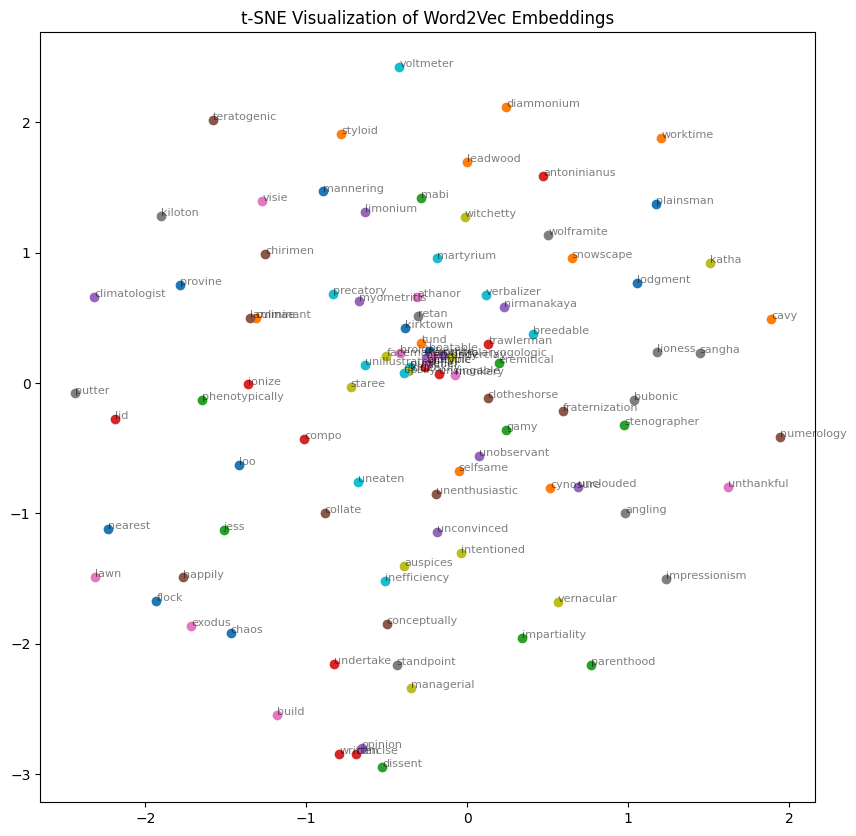

In [106]:
plot_vec(model)

In [107]:
# test_Accuracy(model,'src/questions-words.txt' )

In [108]:
# techx_corpus = import_text_to_list_of_lists('src/TechX_corpus.txt', delimiter='\t')
techx_corpus_norm = import_text_to_list_of_lists('src/TechX_corpus_norm.txt', delimiter='\t')
pointx_corpus_norm = import_text_to_list_of_lists('src/PointX_corpus_norm.txt', delimiter='\t')

In [109]:
####LDA Topic modeling###
data_lemmatized = preprocess_text(techx_corpus_norm)
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  

# Create Corpus 
# Term Document Frequency 
LDA_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

lda_model = gensim.models.ldamodel.LdaModel(corpus=LDA_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [110]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(LDA_corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.959411945311299

Coherence Score:  0.43064822698461774


In [111]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, LDA_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.325624  0.051829       1        1  39.587747
6     -0.291047 -0.101036       2        1   9.049016
0      0.043045 -0.197502       3        1   8.551058
1     -0.003718  0.199239       4        1   8.033891
3      0.082177  0.187018       5        1   7.903075
2      0.068594  0.204750       6        1   7.580949
9      0.145047 -0.041935       7        1   6.379861
4      0.106165 -0.073955       8        1   6.267523
7      0.057051 -0.134781       9        1   4.219329
8      0.118310 -0.093626      10        1   2.427551, topic_info=           Term        Freq       Total Category  logprob  loglift
642      pointx  578.000000  578.000000  Default  30.0000  30.0000
14          scb  505.000000  505.000000  Default  29.0000  29.0000
4       company  410.000000  410.000000  Default  28.0000  28.0000
641       point  592.000000  592.000000  Default  27.0000  27.0000
6          data  144.000000  144.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1018     มถนายน    3.937795    4.846184  Topic10  -4.6590   3.5107
1019      รอนอง    3.937795    4.846184  Topic10  -4.6590   3.5107
1020        วนท    3.937795    4.846184  Topic10  -4.6590   3.5107
1022  หรอคลกลงก    3.937795    4.846184  Topic10  -4.6590   3.5107
768     qr_code   29.016813   40.090975  Topic10  -2.6618   3.3950

[406 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
40        1  0.711448        access
40        9  0.291047        access
663       1  0.986893  accumulation
601       6  0.874869      accuracy
86        5  0.894328      activity
...     ...       ...           ...
1021     10  0.918321   วนท_กมภาพนธ
1022     10  0.825392     หรอคลกลงก
1026     10  0.918321   เดอน_มถนายน
917       7  0.947116        เมษายน
687       2  0.935823           ไทย

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 2, 4, 3, 10, 5, 8, 9])

In [112]:
key = 'scb'
try:
    print(model.wv.most_similar(key,topn=5))
except KeyError:
    print(f"{key} not found")

[('aic', 0.3304489850997925), ('gsc', 0.32839545607566833), ('m&i', 0.3262021243572235), ('laurentian', 0.32590141892433167), ('iob', 0.3192133605480194)]


In [113]:
TechXmodel = train_with_corpus(model,data_lemmatized,epochs=100)

In [114]:
try:
    print(TechXmodel.wv.most_similar(key,topn=5))
except KeyError:
    print(f"{key} not found")

[('บรษท', 0.9900127649307251), ('breezy_hr', 0.9894585013389587), ('co_ltd', 0.989078164100647), ('ทชอบ', 0.988987922668457), ('aef_fae', 0.9889695048332214)]


In [117]:
TechXmodel.wv.most_similar('scb',topn=10)

[('บรษท', 0.9900127649307251),
 ('breezy_hr', 0.9894585013389587),
 ('co_ltd', 0.989078164100647),
 ('ทชอบ', 0.988987922668457),
 ('aef_fae', 0.9889695048332214),
 ('fast_track', 0.9885711669921875),
 ('please_contact', 0.9885415434837341),
 ('call_center', 0.9883933067321777),
 ('enter_joint', 0.9883355498313904),
 ('publicis_sapient', 0.9880448579788208)]